In [1]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Statistics

include("../helpers.jl");
include("../stats.jl");

## Edit before running on new data

In [2]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [3]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

In [4]:
# decorrelate x_df
function dynamicscale(data_raw, dynamic_lower, upper)
    return (data_raw .- dynamic_lower) ./ (upper .- dynamic_lower)
end

max_dvar_3 = 160
eta_3 = 10.
max_dvar_5 = 1.85
eta_5 = 0.05
max_dvar_12 = 2.0
eta_12 = 0.05
max_dvar_9 = -25.
eta_9 = 2.5
max_dvar_13 = -20.
eta_13 = 2.5

dvar_3_prime = dynamicscale(x_df[:, "DVAR3"], eta_3 .+ x_df[:, "DVAR2"], max_dvar_3)
dvar_5_prime = dynamicscale(x_df[:, "DVAR5"], x_df[:, "DVAR4"] .+ eta_5, max_dvar_5)
dvar_12_prime = dynamicscale(x_df[:, "DVAR12"], x_df[:, "DVAR5"] .+ eta_12, max_dvar_12)
dvar_9_prime = dynamicscale(x_df[:, "DVAR9"], x_df[:, "DVAR8"] .+ eta_9, max_dvar_9)
dvar_13_prime = dynamicscale(x_df[:, "DVAR13"], x_df[:, "DVAR9"] .+ eta_13, max_dvar_13)

x_df[:, "DVAR3"] = dvar_3_prime;
x_df[:, "DVAR5"] = dvar_5_prime;
x_df[:, "DVAR12"] = dvar_12_prime;
x_df[:, "DVAR9"] = dvar_9_prime;
x_df[:, "DVAR13"] = dvar_13_prime;

In [5]:
# scaling data
x_scaled_df = minmaxscaledf(x_df)[1]
y_scaled_df = minmaxscaledf(y_df)[1]

@assert(all(maximum(y_scaled_df[!, colname]) == 1. for colname in names(y_scaled_df)))
@assert(all(minimum(y_scaled_df[!, colname]) == -1. for colname in names(y_scaled_df)))

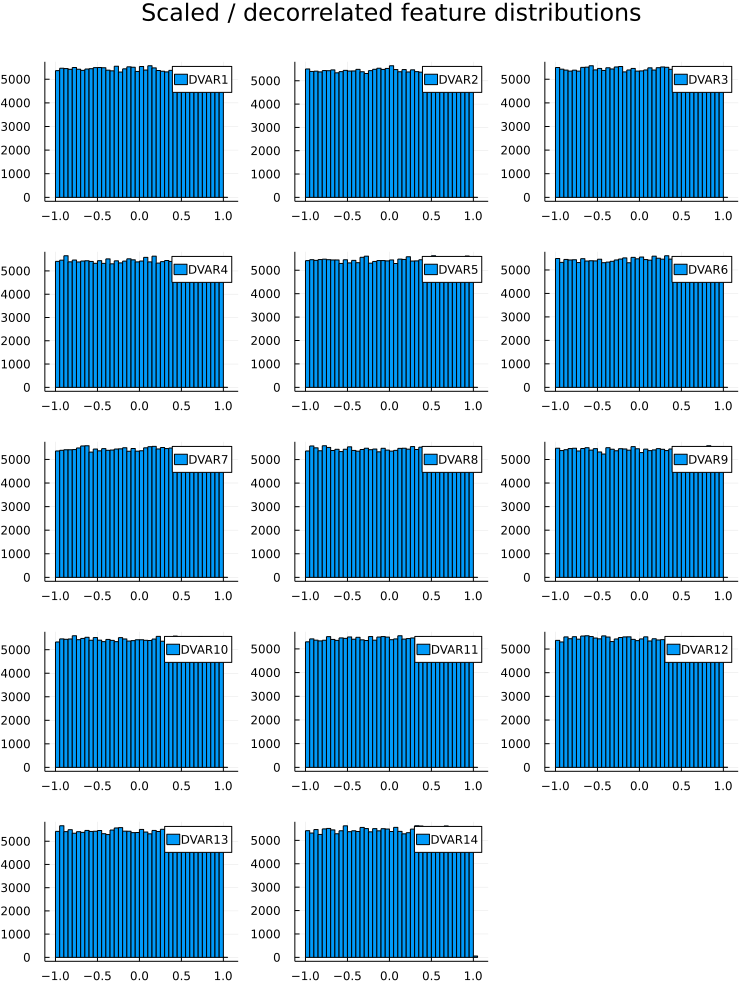

In [6]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_scaled_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Scaled / decorrelated feature distributions")

In [7]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [8]:
# format to arrays
x_train = Float64.(Matrix(x_train_df)); x_test = Float64.(Matrix(x_test_df));
y_train = Float64.(Matrix(y_train_df)); y_test = Float64.(Matrix(y_test_df));

In [9]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

In [10]:
dropout_rate = 0.1

function neuralnetworkwithdropout()
    Chain(
        Dense(x_dimension, 150, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(150, 150, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(150, 150, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(150, 150, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(150, 150, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(150, 150, x->σ.(x)),
        Dropout(dropout_rate),
        Dense(150, y_dimension)
    )
end

neuralnetworkwithdropout (generic function with 1 method)

In [11]:
# organizing data into batches
batch_size = 2048
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [12]:
# defining our model, optimization algorithm and loss function
m = neuralnetworkwithdropout()
learning_rate = 0.01
optimizer = ADAM(learning_rate)
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 1000
training_losses = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
    
    # learning rate decay, just for fun
    if (epoch % 50 == 0) & (epoch < 151)
        learning_rate = learning_rate * 0.1
        optimizer = ADAM(learning_rate)
    end
end

epoch 1, loss=7.384762489691898
epoch 2, loss=7.386360842782846
epoch 3, loss=7.38217408469503
epoch 4, loss=7.378188617669552
epoch 5, loss=7.378588214854947
epoch 6, loss=7.318936686327543
epoch 7, loss=4.545937065132355
epoch 8, loss=3.8663884485566498
epoch 9, loss=3.360169796318094
epoch 10, loss=1.8151892373687586
epoch 11, loss=1.0807819604948374
epoch 12, loss=0.8844699381395815
epoch 13, loss=0.7939300825038894
epoch 14, loss=0.7309111748023088
epoch 15, loss=0.681124357704285
epoch 16, loss=0.6645103451154557
epoch 17, loss=0.6427813895525643
epoch 18, loss=0.6240190120682098
epoch 19, loss=0.6076318141371788
epoch 20, loss=0.6044743741691114
epoch 21, loss=0.5846679115922901
epoch 22, loss=0.5818205206616339
epoch 23, loss=0.5963874386985633
epoch 24, loss=0.5842760987557366
epoch 25, loss=0.5736550409638734
epoch 26, loss=0.5582963331611966
epoch 27, loss=0.5563534152837452
epoch 28, loss=0.5515173488753907
epoch 29, loss=0.5467258365076089
epoch 30, loss=0.5478728969935331

LoadError: InterruptException:

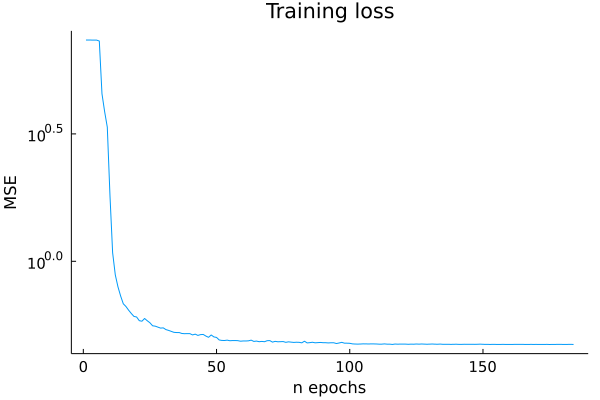

In [22]:
# plot training history
plot(epochs[1:184], training_losses;
    title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false,
    label="w5, d200, dropout_rate=$dropout_rate", dpi=400,
    grid=false, xtickfontsize=10, ytickfontsize=10, legendfontsize=10, yaxis=:log)

## Model evaluation

In [14]:
y_train_preds = m(x_train')';
y_test_preds = m(x_test')';

In [15]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [16]:
r2_train = r2score_multidim(y_train, y_train_preds)
r2_test = r2score_multidim(y_test, y_test_preds)
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.8837372995851044
r2 on test set: 0.8868763046684617


In [17]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [18]:
adjustedr2_train = adjustedr2score_multidim(y_train, y_train_preds, size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, y_test_preds, size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.8837279353740238
adjustedr2 on test set: 0.8868398501123748


In [19]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

println("MAPEs on test sets")
for i in 1:y_dimension
    temp_train_trues_normalized = y_train[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_test_preds_normalized = y_test_preds[:, i]
    
    # unnormalize
    y_scaler = MinMaxScaler(0., 0.)
    fit!(y_scaler, y_df[!, "OBJ$i"])
    
    temp_train_trues_original = inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_trues_original = inverse_transform(y_scaler, temp_test_trues_normalized)
    temp_train_preds_original = inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_test_preds_original = inverse_transform(y_scaler, temp_test_preds_normalized)
    
    println(
        "OBJ$i: ",
        mape(temp_test_preds_original, temp_test_trues_original)
    )
end

MAPEs on test sets
OBJ1: 0.02917245818711759
OBJ2: 0.018298418545179485
OBJ3: 0.022207583585156874
OBJ4: 0.1514242853303181
OBJ5: 0.12129945565946194
OBJ6: 0.11991987948144381


In [20]:
i = 7
println("true: ", y_test[i, :])
println("predicted: ", y_test_preds[i, :])

true: [0.7086864011656806, -0.6951219816911047, -0.6612205452613151, -0.8978997729350763, -0.47822490066931955, -0.4063631817092872]
predicted: [0.7063455763444292, -0.6468698843756518, -0.6572456451120738, -0.8968299380972935, -0.3967655753979056, -0.42707453259331174]


In [23]:
x_df

,DVAR1,DVAR2,DVAR3,DVAR4,DVAR5,DVAR6,DVAR7,DVAR8,DVAR9
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,10.7561,51.3217,0.573772,1.58493,0.776724,54.7152,46.9082,-73.5071,0.665672
2,10.9999,59.0984,0.504597,1.42384,0.420459,94.2397,329.885,-69.9227,0.150901
3,10.5114,67.2372,0.309129,1.56805,0.616469,232.236,482.175,-34.481,0.132712
4,9.79078,132.062,0.88238,1.06108,0.501705,91.7427,178.76,-35.0063,0.565793
5,10.8851,33.3697,0.863196,1.67219,0.863156,433.296,420.627,-32.8443,0.798408
6,10.8307,23.7125,0.727359,1.60792,0.0847564,154.401,100.149,-77.6295,0.25453
7,9.17733,116.862,0.878776,1.00854,0.312839,394.73,267.636,-77.0763,0.459301
8,8.97374,12.9862,0.100264,1.34091,0.774837,352.228,300.074,-88.2668,0.843687
9,8.86703,118.879,0.184075,1.24142,0.088349,459.08,357.449,-33.9325,0.518018
